Data shape: (6310, 32)

Missing values:
 user_snippet                  0
x-axis__sum_values            0
x-axis__median                0
x-axis__mean                  0
x-axis__length                0
x-axis__standard_deviation    0
x-axis__variance              0
x-axis__root_mean_square      0
x-axis__maximum               0
x-axis__absolute_maximum      0
x-axis__minimum               0
y-axis__sum_values            0
y-axis__median                0
y-axis__mean                  0
y-axis__length                0
y-axis__standard_deviation    0
y-axis__variance              0
y-axis__root_mean_square      0
y-axis__maximum               0
y-axis__absolute_maximum      0
y-axis__minimum               0
z-axis__sum_values            0
z-axis__median                0
z-axis__mean                  0
z-axis__length                0
z-axis__standard_deviation    0
z-axis__variance              0
z-axis__root_mean_square      0
z-axis__maximum               0
z-axis__absolute_maximum      0

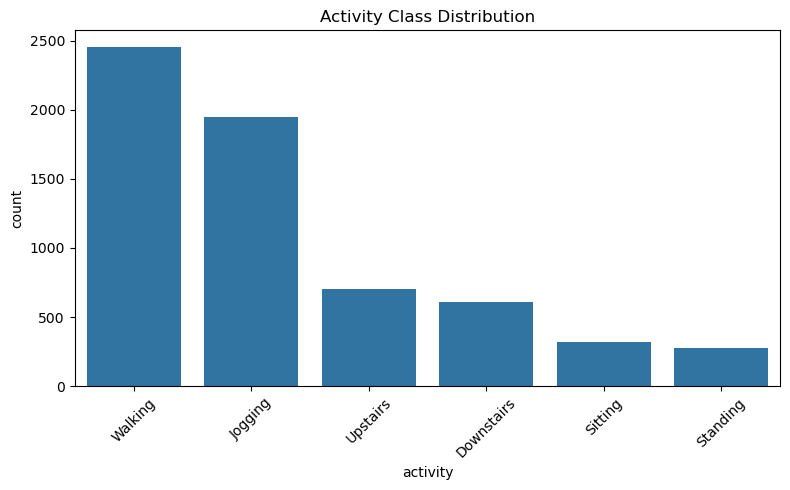

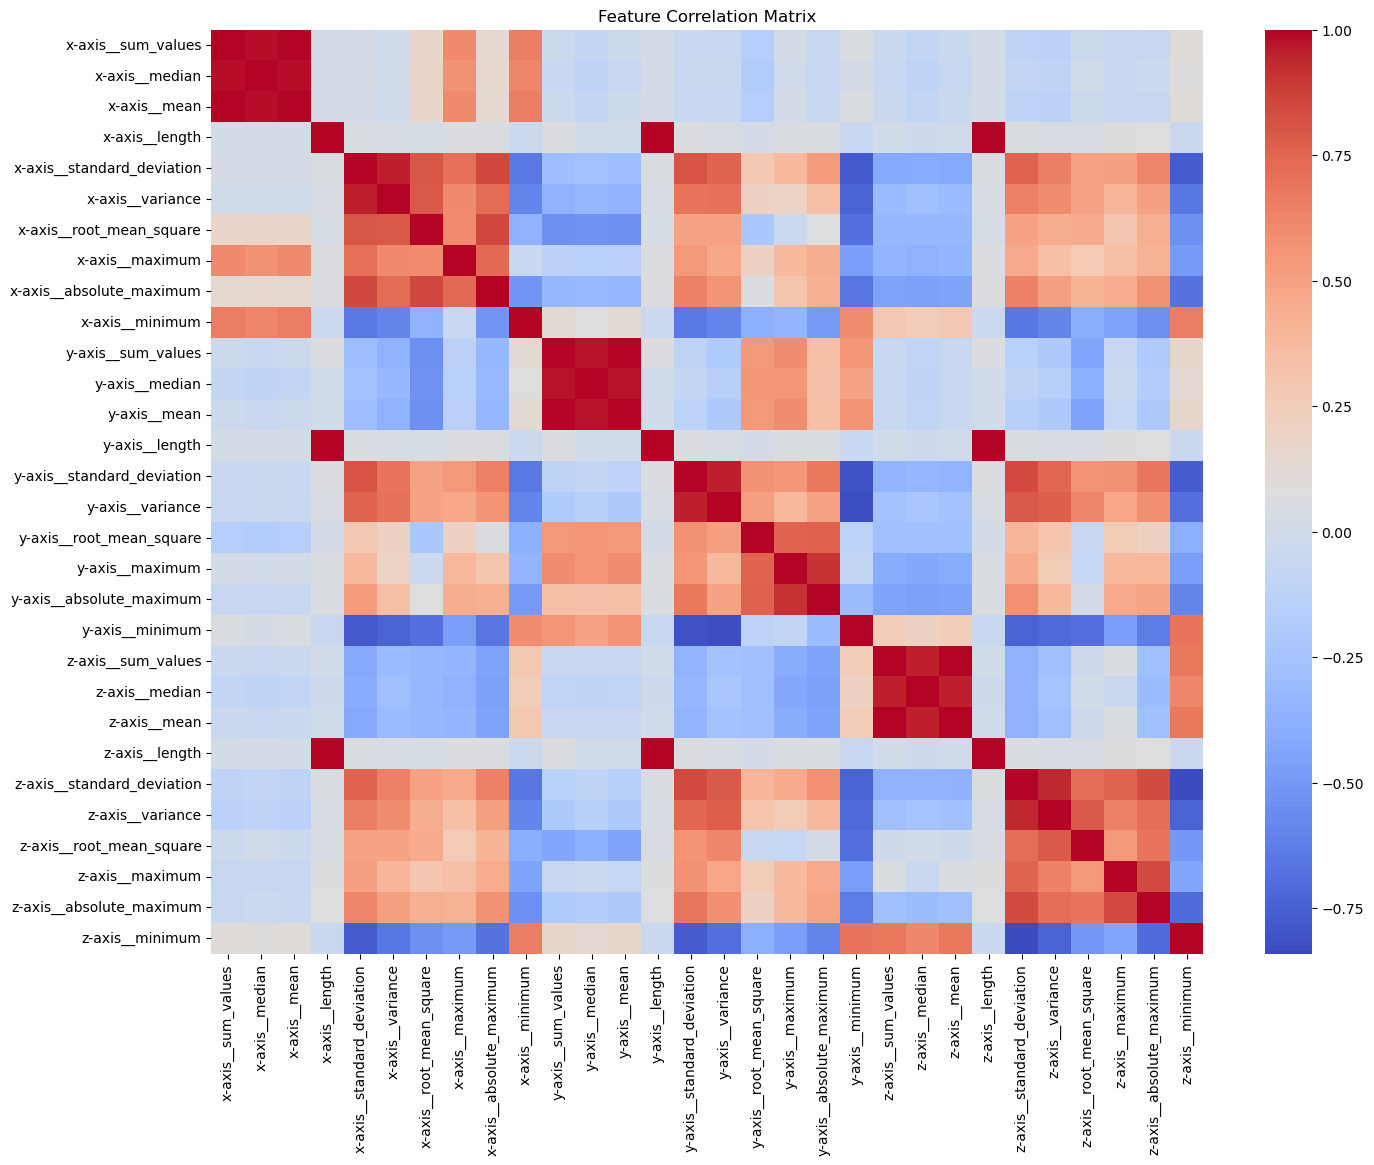

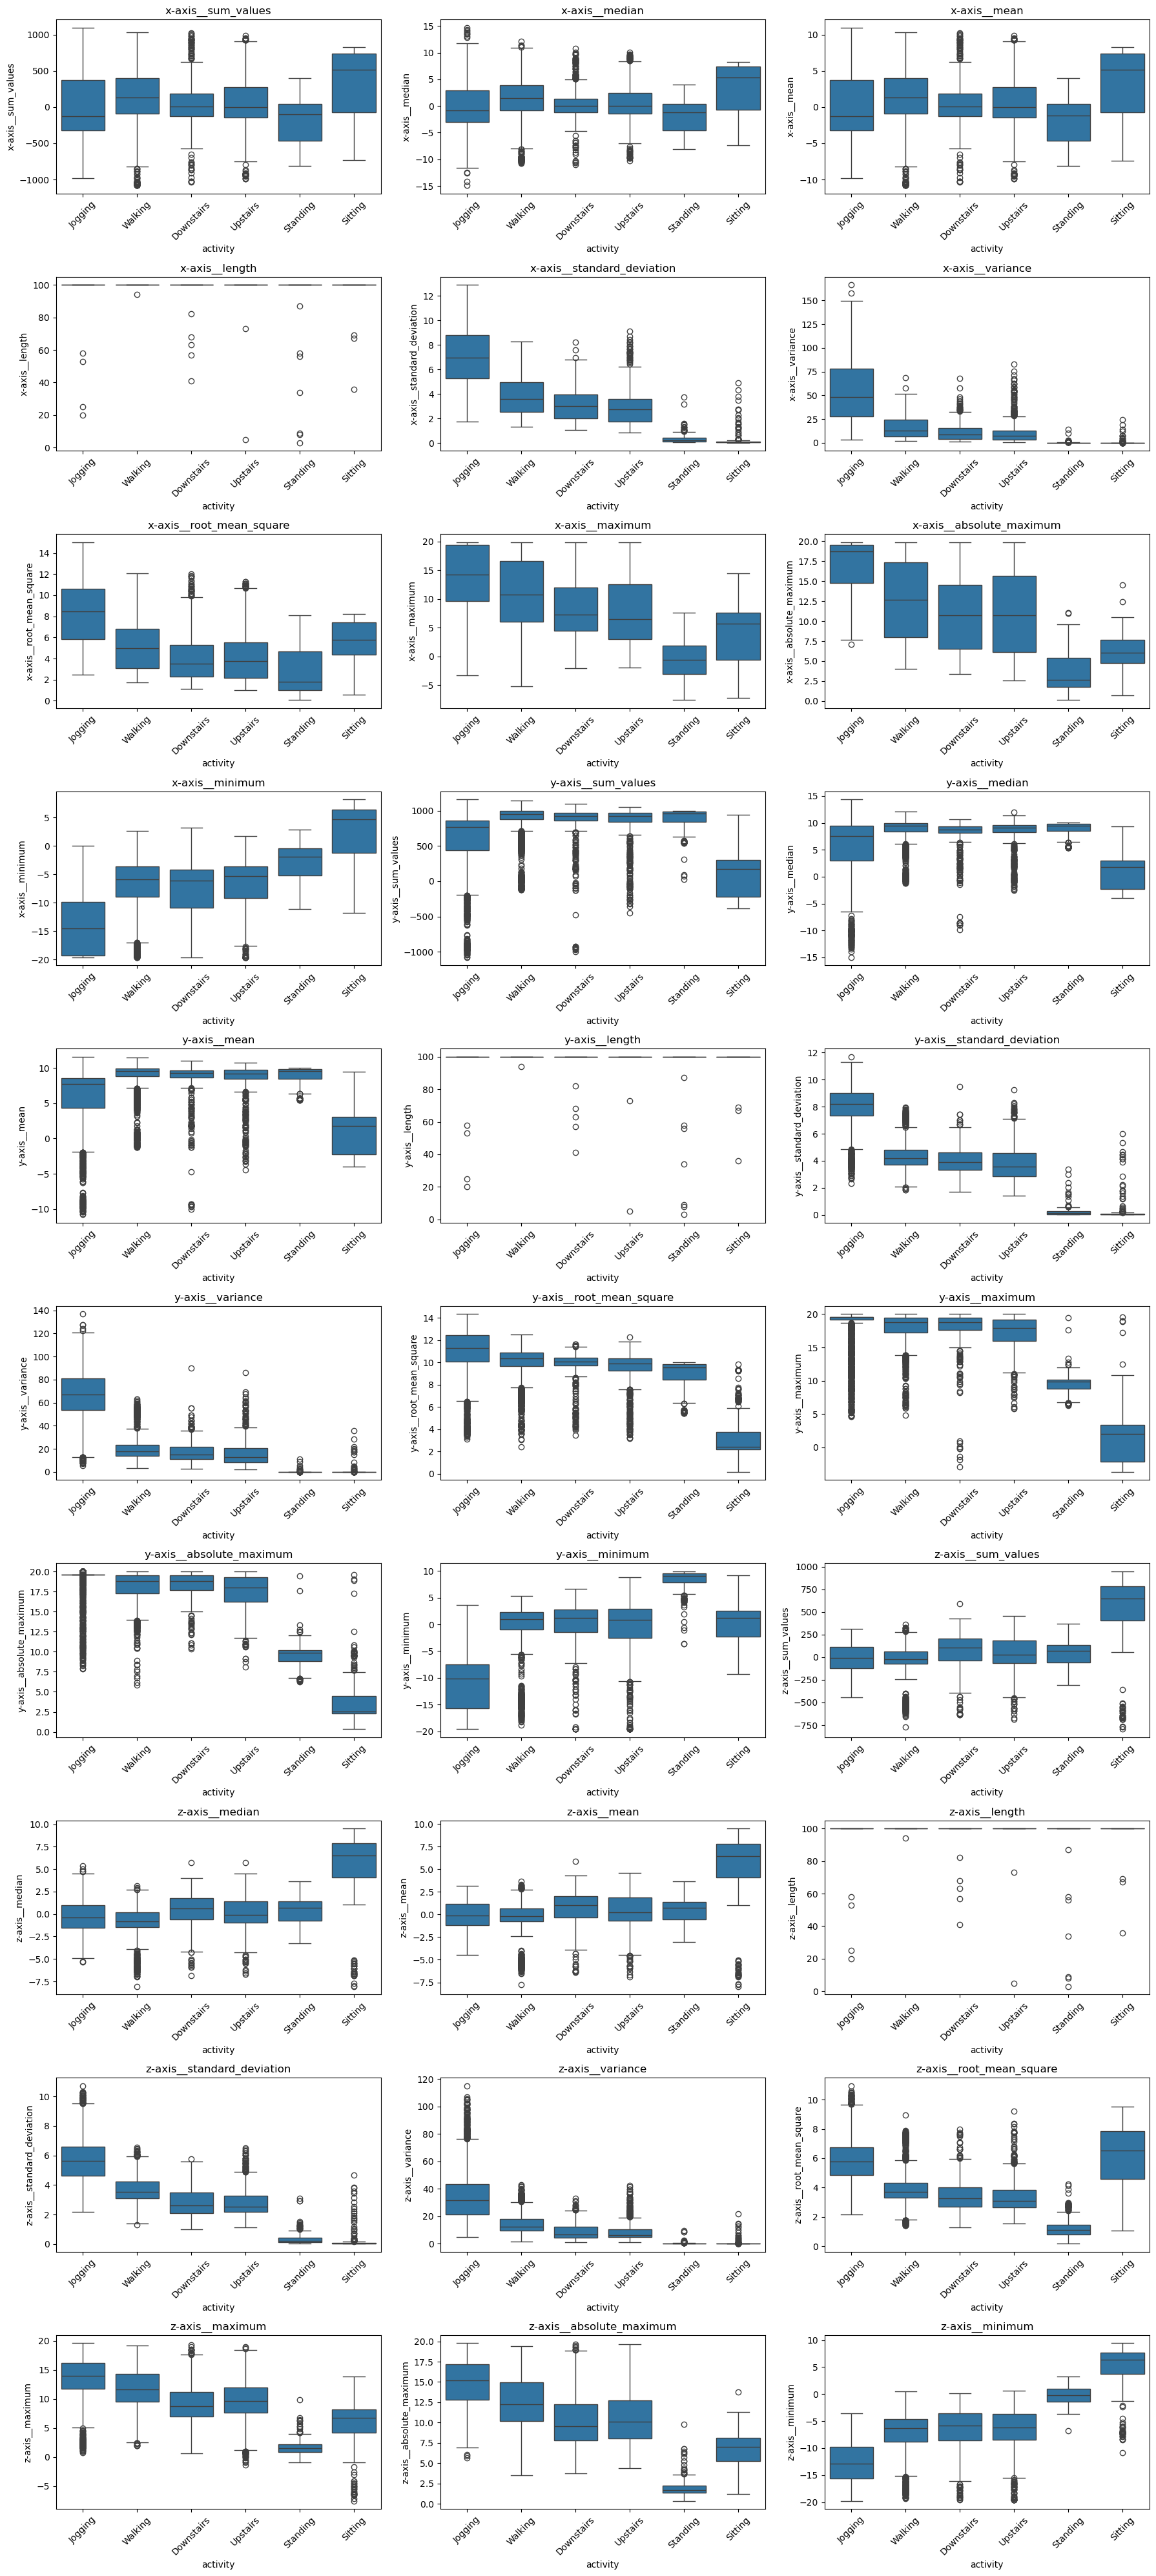

In [62]:
 # STEP 1: EDA of metadata.csv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

signals_df = pd.read_csv("/Users/lyndadjellouli/Desktop/7021CW/signals.csv")

# Load the metadata file
metadata_path = "/Users/lyndadjellouli/Desktop/7021CW/metadata.csv"  # adjust path if needed
df = pd.read_csv(metadata_path)

# Show basic info
print("Data shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nClass distribution:\n", df['activity'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='activity', order=df['activity'].value_counts().index)
plt.title("Activity Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Encode activity for color mapping
le = LabelEncoder()
df['activity_encoded'] = le.fit_transform(df['activity'])

# List of feature columns (exclude non-feature columns)
feature_cols = [col for col in df.columns if '__' in col]

# Correlation Matrix (Pearson)
plt.figure(figsize=(16, 12))
corr_matrix = df[feature_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# Feature Distributions by Class (Boxplots)
import math

# One plot per feature grouped by activity
n_cols = 3
n_rows = math.ceil(len(feature_cols) / n_cols)
plt.figure(figsize=(n_cols*6, n_rows*4))

for i, feature in enumerate(feature_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(data=df, x='activity', y=feature)
    plt.title(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [64]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import find_peaks, welch
from statsmodels.tsa.stattools import acf
from numpy.lib.stride_tricks import sliding_window_view

# Simulate a sample snippet_df for structure only
def compute_features_with_axes_enhanced(snippet_df):
    x = snippet_df['x-axis'].values
    y = snippet_df['y-axis'].values
    z = snippet_df['z-axis'].values
    timestamp = snippet_df['timestamp'].values
    dt = np.mean(np.diff(timestamp) / 1000)

    mag = np.sqrt(x**2 + y**2 + z**2)
    jerk = np.gradient(mag, dt)
    dominant_axis = np.argmax([np.std(x), np.std(y), np.std(z)])
    dominant_axis_map = {0: 'x', 1: 'y', 2: 'z'}

    peaks, _ = find_peaks(mag, distance=5)
    step_count = len(peaks)
    peak_amplitude = np.max(mag[peaks]) if step_count > 0 else 0

    freqs, psd = welch(mag, fs=1/dt)
    spectral_entropy = entropy(psd / np.sum(psd)) if np.sum(psd) > 0 else 0
    dominant_freq = freqs[np.argmax(psd)]
    spectral_energy = np.sum(psd)
    time_energy = np.sum(mag ** 2)
    zcr = ((mag[:-1] * mag[1:]) < 0).sum()
    autocorr = acf(mag, nlags=1, fft=False)[1] if len(mag) > 1 else 0
    cv = np.std(mag) / np.mean(mag) if np.mean(mag) != 0 else 0

    def approximate_entropy(U, m, r):
        def _phi(m):
            x = sliding_window_view(U, window_shape=m)
            C = np.sum(np.max(np.abs(x[:, None] - x[None, :]), axis=2) <= r, axis=0) / len(x)
            return np.sum(np.log(C)) / len(C)
        return abs(_phi(m) - _phi(m + 1))
    ap_en = approximate_entropy(mag, 2, 0.2 * np.std(mag)) if len(mag) > 20 else 0

    # Axis Correlations
    corr_xy = np.corrcoef(x, y)[0, 1]
    corr_yz = np.corrcoef(y, z)[0, 1]
    corr_xz = np.corrcoef(x, z)[0, 1]

    # SMA
    sma = np.sum(np.abs(x) + np.abs(y) + np.abs(z)) / len(x)

    # Tilt Angles
    pitch = np.arctan2(x, np.sqrt(y**2 + z**2)).mean()
    roll = np.arctan2(y, np.sqrt(x**2 + z**2)).mean()

    # Direction changes
    x_changes = np.sum(np.diff(np.sign(x)) != 0)
    y_changes = np.sum(np.diff(np.sign(y)) != 0)
    z_changes = np.sum(np.diff(np.sign(z)) != 0)

    # Axis-specific features
    axis_features = {}
    for axis_label, axis_data in zip(['x', 'y', 'z'], [x, y, z]):
        axis_features[f'{axis_label}_skew'] = skew(axis_data)
        axis_features[f'{axis_label}_kurtosis'] = kurtosis(axis_data)
        axis_features[f'{axis_label}_iqr'] = np.subtract(*np.percentile(axis_data, [75, 25]))
        axis_features[f'{axis_label}_mad'] = np.mean(np.abs(axis_data - np.mean(axis_data)))
        axis_features[f'{axis_label}_range'] = np.ptp(axis_data)
        axis_features[f'{axis_label}_cv'] = np.std(axis_data) / np.mean(axis_data) if np.mean(axis_data) != 0 else 0
        axis_features[f'{axis_label}_zcr'] = ((axis_data[:-1] * axis_data[1:]) < 0).sum()

    return {
        'jerk_mean': np.mean(jerk),
        'jerk_std': np.std(jerk),
        'mag_mean': np.mean(mag),
        'mag_std': np.std(mag),
        'dominant_axis': dominant_axis_map[dominant_axis],
        'step_count': step_count,
        'peak_amplitude': peak_amplitude,
        'skewness': skew(mag),
        'kurtosis': kurtosis(mag),
        'spectral_entropy': spectral_entropy,
        'dominant_freq': dominant_freq,
        'spectral_energy': spectral_energy,
        'time_energy': time_energy,
        'zcr': zcr,
        'iqr': np.subtract(*np.percentile(mag, [75, 25])),
        'mad': np.mean(np.abs(mag - np.mean(mag))),
        'range': np.ptp(mag),
        'autocorr_lag1': autocorr,
        'cv': cv,
        'approx_entropy': ap_en,
        'corr_xy': corr_xy,
        'corr_yz': corr_yz,
        'corr_xz': corr_xz,
        'sma': sma,
        'pitch': pitch,
        'roll': roll,
        'x_direction_changes': x_changes,
        'y_direction_changes': y_changes,
        'z_direction_changes': z_changes,
        **axis_features
    }


In [66]:
# Recompute features from all user_snippets
all_features = []
for snippet_id, snippet_data in signals_df.groupby('user_snippet'):
    feats = compute_features_with_axes_enhanced(snippet_data)
    feats['user_snippet'] = snippet_id
    all_features.append(feats)

# Create and merge enriched dataframe
features_df = pd.DataFrame(all_features)
merged_df = pd.merge(df, features_df, on='user_snippet')

# Save it
merged_df.to_csv("/Users/lyndadjellouli/Desktop/7021CW/metadata_enriched_super.csv", index=False)


In [68]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, iqr, entropy
from scipy.signal import find_peaks, welch
from numpy.lib.stride_tricks import sliding_window_view
from statsmodels.tsa.stattools import acf
import warnings

warnings.filterwarnings("ignore")

# Paths
signals_test_path ="/Users/lyndadjellouli/Desktop/7021CW/signals_test.csv"
signals_kaggle_path = "/Users/lyndadjellouli/Desktop/7021CW/signals_kaggle.csv"
metadata_test_path = "/Users/lyndadjellouli/Desktop/7021CW/metadata_test.csv"
metadata_kaggle_path = "/Users/lyndadjellouli/Desktop/7021CW/metadata_kaggle.csv"

# Load data
signals_test_df = pd.read_csv(signals_test_path)
signals_kaggle_df = pd.read_csv(signals_kaggle_path)
metadata_test_df = pd.read_csv(metadata_test_path)
metadata_kaggle_df = pd.read_csv(metadata_kaggle_path)

# Feature extraction function (enhanced with SHAP-inspired features)
def compute_features_with_axes_enhanced(snippet_df):
    x = snippet_df['x-axis'].values
    y = snippet_df['y-axis'].values
    z = snippet_df['z-axis'].values
    timestamp = snippet_df['timestamp'].values
    dt = np.mean(np.diff(timestamp) / 1000)

    mag = np.sqrt(x**2 + y**2 + z**2)
    jerk = np.gradient(mag, dt)
    dominant_axis = np.argmax([np.std(x), np.std(y), np.std(z)])
    dominant_axis_map = {0: 'x', 1: 'y', 2: 'z'}

    peaks, _ = find_peaks(mag, distance=5)
    step_count = len(peaks)
    peak_amplitude = np.max(mag[peaks]) if step_count > 0 else 0

    freqs, psd = welch(mag, fs=1/dt)
    spectral_entropy = entropy(psd / np.sum(psd)) if np.sum(psd) > 0 else 0
    dominant_freq = freqs[np.argmax(psd)]
    spectral_energy = np.sum(psd)
    time_energy = np.sum(mag ** 2)
    zcr = ((mag[:-1] * mag[1:]) < 0).sum()
    autocorr = acf(mag, nlags=1, fft=False)[1] if len(mag) > 1 else 0
    cv = np.std(mag) / np.mean(mag) if np.mean(mag) != 0 else 0

    # Additional shape/tilt features
    pitch = np.arctan2(y, np.sqrt(x**2 + z**2)).mean()
    roll = np.arctan2(x, np.sqrt(y**2 + z**2)).mean()
    sma = np.sum(np.abs(x) + np.abs(y) + np.abs(z)) / len(x)

    # Directional changes
    x_changes = np.sum(np.diff(np.sign(x)) != 0)
    y_changes = np.sum(np.diff(np.sign(y)) != 0)
    z_changes = np.sum(np.diff(np.sign(z)) != 0)

    def approximate_entropy(U, m, r):
        def _phi(m):
            x = sliding_window_view(U, window_shape=m)
            C = np.sum(np.max(np.abs(x[:, None] - x[None, :]), axis=2) <= r, axis=0) / len(x)
            return np.sum(np.log(C)) / len(C)
        return abs(_phi(m) - _phi(m + 1))

    ap_en = approximate_entropy(mag, 2, 0.2 * np.std(mag)) if len(mag) > 20 else 0

    axis_features = {}
    for axis_label, axis_data in zip(['x', 'y', 'z'], [x, y, z]):
        axis_features[f'{axis_label}_skew'] = skew(axis_data)
        axis_features[f'{axis_label}_kurtosis'] = kurtosis(axis_data)
        axis_features[f'{axis_label}_iqr'] = iqr(axis_data)
        axis_features[f'{axis_label}_mad'] = np.mean(np.abs(axis_data - np.mean(axis_data)))
        axis_features[f'{axis_label}_range'] = np.ptp(axis_data)
        axis_features[f'{axis_label}_cv'] = np.std(axis_data) / np.mean(axis_data) if np.mean(axis_data) != 0 else 0
        axis_features[f'{axis_label}_zcr'] = ((axis_data[:-1] * axis_data[1:]) < 0).sum()

    # Axis correlation
    corr_xy = np.corrcoef(x, y)[0, 1] if len(x) > 1 else 0
    corr_yz = np.corrcoef(y, z)[0, 1] if len(y) > 1 else 0
    corr_xz = np.corrcoef(x, z)[0, 1] if len(z) > 1 else 0

    return {
        'jerk_mean': np.mean(jerk),
        'jerk_std': np.std(jerk),
        'mag_mean': np.mean(mag),
        'mag_std': np.std(mag),
        'dominant_axis': dominant_axis_map[dominant_axis],
        'step_count': step_count,
        'peak_amplitude': peak_amplitude,
        'skewness': skew(mag),
        'kurtosis': kurtosis(mag),
        'spectral_entropy': spectral_entropy,
        'dominant_freq': dominant_freq,
        'spectral_energy': spectral_energy,
        'time_energy': time_energy,
        'zcr': zcr,
        'iqr': iqr(mag),
        'mad': np.mean(np.abs(mag - np.mean(mag))),
        'range': np.ptp(mag),
        'autocorr_lag1': autocorr,
        'cv': cv,
        'approx_entropy': ap_en,
        'sma': sma,
        'pitch': pitch,
        'roll': roll,
        'x_direction_changes': x_changes,
        'y_direction_changes': y_changes,
        'z_direction_changes': z_changes,
        'corr_xy': corr_xy,
        'corr_yz': corr_yz,
        'corr_xz': corr_xz,
        **axis_features
    }

# Apply feature extraction and merge
def extract_features_and_merge(signals_df, metadata_df):
    enriched_rows = []
    for snippet_id, snippet_data in signals_df.groupby('user_snippet'):
        feats = compute_features_with_axes_enhanced(snippet_data)
        feats['user_snippet'] = snippet_id
        enriched_rows.append(feats)
    features_df = pd.DataFrame(enriched_rows)
    merged_df = pd.merge(metadata_df, features_df, on='user_snippet')
    return merged_df

# Process files
metadata_test_enriched = extract_features_and_merge(signals_test_df, metadata_test_df)
metadata_kaggle_enriched = extract_features_and_merge(signals_kaggle_df, metadata_kaggle_df)

import os
test_output_path = "/Users/lyndadjellouli/Desktop/7021CW/metadata_test_enriched_super.csv"
kaggle_output_path = "/Users/lyndadjellouli/Desktop/7021CW/metadata_kaggle_enriched_super.csv"
metadata_test_enriched.to_csv(test_output_path, index=False)
metadata_kaggle_enriched.to_csv(kaggle_output_path, index=False)

test_output_path, kaggle_output_path


('/Users/lyndadjellouli/Desktop/7021CW/metadata_test_enriched_super.csv',
 '/Users/lyndadjellouli/Desktop/7021CW/metadata_kaggle_enriched_super.csv')

In [ ]:
mport pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load enriched datasets
train_df = pd.read_csv("/Users/lyndadjellouli/Desktop/7021CW/metadata_enriched_super.csv")
test_df = pd.read_csv("/Users/lyndadjellouli/Desktop/7021CW/metadata_test_enriched_super.csv")
kaggle_df = pd.read_csv("/Users/lyndadjellouli/Desktop/7021CW/metadata_kaggle_enriched_super.csv")

# Step 1: Encode 'dominant_axis' consistently across ALL datasets
from sklearn.preprocessing import LabelEncoder

axis_encoder = LabelEncoder()
all_axes = pd.concat([
    train_df["dominant_axis"],
    test_df["dominant_axis"],
    kaggle_df["dominant_axis"]
])
axis_encoder.fit(all_axes)

for df in [train_df, test_df, kaggle_df]:
    df["dominant_axis"] = axis_encoder.transform(df["dominant_axis"])

# Step 2: Prepare features and labels AFTER encoding
X_train = train_df.drop(columns=["user_snippet", "activity"])
y_train = train_df["activity"]
X_test = test_df.drop(columns=["user_snippet", "activity"])
y_test = test_df["activity"]
X_kaggle = kaggle_df.drop(columns=["user_snippet"])
kaggle_ids = kaggle_df["user_snippet"]

# Find common columns in all three datasets
common_cols = list(set(X_train.columns) & set(X_test.columns) & set(X_kaggle.columns))

# Align all feature sets
X_train = X_train[common_cols]
X_test = X_test[common_cols]
X_kaggle = X_kaggle[common_cols]

# Step 3: Check alignment of columns
assert list(X_train.columns) == list(X_test.columns) == list(X_kaggle.columns)

# Step 4: Encode activity target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Define classifiers and their param grids
models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(),
    "LightGBM": lgb.LGBMClassifier(class_weight="balanced", n_jobs=-1)
}

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200, 300, 1000],
        "max_depth": [10, 20, 50, None],
        "min_samples_split": [2, 5, 10],
    },
    "GradientBoosting": {
        "n_estimators": [100, 150, 250, 500],
        "learning_rate": [0.05, 0.075, 0.1, 0.15],
        "max_depth": [3, 5, 20, 50],
    },
    "LightGBM": {
        "n_estimators": [100, 150, 250, 350],
        "learning_rate": [0.05, 0.075, 0.1, 0.15],
        "num_leaves": [31, 50, 70, 100],
    }
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track best model
best_model = None
best_score = 0
best_name = ""

for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=10,
        scoring="balanced_accuracy",
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train_enc)
    print(f" Best {name} score: {search.best_score_:.4f}")
    print("Best Params:", search.best_params_)

    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_name = name

# Evaluate on test set
print(f"\n Evaluating best model ({best_name}) on test set:")
y_pred = best_model.predict(X_test)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_enc, y_pred))

# Final training on all training data
print("\n Training on full data and predicting on Kaggle set...")
best_model.fit(X_train, y_train_enc)
kaggle_preds = best_model.predict(X_kaggle)
kaggle_labels = le.inverse_transform(kaggle_preds)

# Save predictions
submission_df = pd.DataFrame({
    "user_snippet": kaggle_ids,
    "activity": kaggle_labels
})
submission_df.to_csv("predictions_TEAMNAME.csv", index=False)
print(" Saved predictions to predictions_TEAMNAME.csv")

# Plot feature importance
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[sorted_idx])
    plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx])
    plt.title(f"Top {top_n} Feature Importances - {best_name}")
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_model, X_train.columns)